Нужно реализовать rest api на базе flask (пример https://github.com/fimochka-sudo/GB_docker_flask_example)

Возьмем датасет c https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009/version/2?select=winequality-red.csv

This dataset is also available from the UCI machine learning repository, https://archive.ics.uci.edu/ml/datasets/wine+quality , I just shared it to kaggle for convenience. (If I am mistaken and the public license type disallowed me from doing so, I will take this down if requested.)
Content

For more information, read [Cortez et al., 2009].

Input variables (based on physicochemical tests):

1 - фиксированная кислотность, fixed acidity
2 - летучая кислотность, volatile acidity
3 - лимонная кислота, citric acid
4 - остаточный сахар, residual sugar
5 - хлориды, chlorides
6 - свободный диоксид серы, free sulfur dioxide
7 - общий диоксид серы, total sulfur dioxide
8 - плотность, density
9 - pH, pH
10 - сульфаты, sulphates
11 - алкоголь, alcohol

Output variable (based on sensory data):

12 - quality (score between 0 and 10)

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dill

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

Загрузим датасет

In [26]:
wine = pd.read_csv('winequality-red.csv')
wine.sort_values('quality', ascending=False).head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
495,10.7,0.35,0.53,2.6,0.070,5.0,16.0,0.99720,3.15,0.65,11.0,8
1403,7.2,0.33,0.33,1.7,0.061,3.0,13.0,0.99600,3.23,1.10,10.0,8
390,5.6,0.85,0.05,1.4,0.045,12.0,88.0,0.99240,3.56,0.82,12.9,8
1061,9.1,0.40,0.50,1.8,0.071,7.0,16.0,0.99462,3.21,0.69,12.5,8
1202,8.6,0.42,0.39,1.8,0.068,6.0,12.0,0.99516,3.35,0.69,11.7,8


In [27]:
wine.shape

(1599, 12)

Сразу видим примерно что у нас есть 12 колонок, 1599 записей. Переименуем колонки для удобства

In [28]:
wine.rename(columns={
    'fixed acidity': 'fixed_acidity',
    'volatile acidity': 'volatile_acidity',
    'citric acid': 'citric_acid',
    'residual sugar': 'residual_sugar',
    'free sulfur dioxide': 'free_sulfur_dioxide',
    'total sulfur dioxide': 'total_sulfur_dioxide',
},
    inplace=True)
wine.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [29]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         1599 non-null   float64
 1   volatile_acidity      1599 non-null   float64
 2   citric_acid           1599 non-null   float64
 3   residual_sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free_sulfur_dioxide   1599 non-null   float64
 6   total_sulfur_dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Пропусков нет, все целочисленные

Тогда сразу преобразуем типы для уменьшения потребляемой памяти

In [30]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2
    print("Memory usage of properties dataframe is :", start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in.
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings

            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)

            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()

            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all():
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)

                # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            try:
                result = (props[col] - asint)
                result = result.sum()
                if result > -0.01 and result < 0.01:
                    IsInt = True

                # Make Integer/unsigned Integer datatypes
                if IsInt:
                    if mn >= 0:
                        if mx < 255:
                            props[col] = props[col].astype(np.uint8)
                        elif mx < 65535:
                            props[col] = props[col].astype(np.uint16)
                        elif mx < 4294967295:
                            props[col] = props[col].astype(np.uint32)
                        else:
                            props[col] = props[col].astype(np.uint64)
                    else:
                        if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                            props[col] = props[col].astype(np.int8)
                        elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                            props[col] = props[col].astype(np.int16)
                        elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                            props[col] = props[col].astype(np.int32)
                        elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                            props[col] = props[col].astype(np.int64)

                            # Make float datatypes 32 bit
                else:
                    props[col] = props[col].astype(np.float32)

                # Print new column type
                print("dtype after: ",props[col].dtype)
                print("******************************")
            except TypeError:
                pass

    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist
wine, NAlist = reduce_mem_usage(wine)

Memory usage of properties dataframe is : 0.146514892578125  MB
******************************
Column:  fixed_acidity
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  volatile_acidity
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  citric_acid
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  residual_sugar
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  chlorides
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  free_sulfur_dioxide
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  total_sulfur_dioxide
dtype before:  float64
dtype after:  float32
******************************
***************

Построим корреляции

Text(0.5, 1.0, 'Матрица корреляций wine')

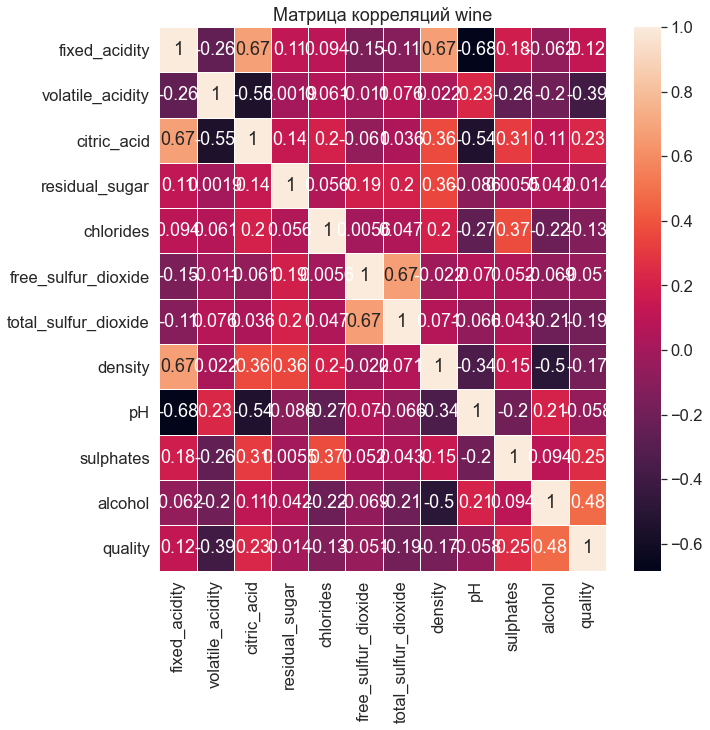

In [31]:
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(wine.corr(), annot=True, linewidths=.5)
plt.title("Матрица корреляций wine")

Видны зависимости фичей
- citrix_acid и fixed_acidity - 0.67,
- density и fixed_acidity - 0.67,
- total_sulfur_dioxide и free_sulfur_dioxide - 0.67;
- есть и обратные зависимости между pH и fixed_acidity - 0.68

Можно еще добавить, что с таргетом больше всего коррелирует фича alcohol - 0.48

Разобьем наш таргет на группы по качеству: хорошее и плохое в зависимости от вхождения в промежуток:

In [32]:
bins = (2, 6.5, 8)
group_names = ['bad', 'good']
wine['quality'] = pd.cut(wine['quality'], bins=bins, labels=group_names)

In [33]:
wine['quality']

0       bad
1       bad
2       bad
3       bad
4       bad
       ... 
1594    bad
1595    bad
1596    bad
1597    bad
1598    bad
Name: quality, Length: 1599, dtype: category
Categories (2, object): [bad < good]

In [34]:
# Тогда bad станет 0, а good станет 1
label_quality = LabelEncoder()
wine['quality'] = label_quality.fit_transform(wine['quality'])

In [35]:
wine['quality'].value_counts()

0    1382
1     217
Name: quality, dtype: int64

<AxesSubplot:xlabel='quality', ylabel='count'>

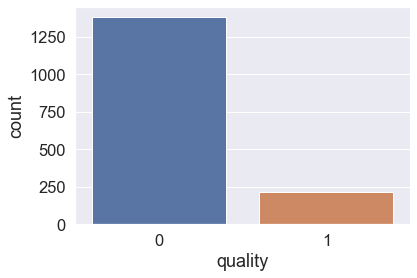

In [36]:
sns.countplot(wine['quality'])

Разобьем датасет

In [37]:
X = wine.drop('quality', axis=1)
y = wine['quality']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 13)

In [39]:
X_train.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [40]:
# соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

continuos_cols = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
                  'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
                  'pH', 'sulphates', 'alcohol']

continuos_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
        ('selector', NumberSelector(key=cont_col)),
        ('standard', StandardScaler())
    ])
    continuos_transformers.append((cont_col, transfomer))

feats = FeatureUnion(continuos_transformers)

feature_processing = Pipeline([('feats', feats)])


feature_processing.fit_transform(X_train)

array([[ 0.02872636,  0.3722799 , -0.8794403 , ..., -1.0211363 ,
         0.02741279, -0.5906703 ],
       [ 1.3388811 ,  2.0076768 ,  0.34539184, ..., -0.5707136 ,
         0.14506622, -1.0546218 ],
       [-0.42697945, -0.55444515,  0.09021841, ...,  0.5875178 ,
        -0.09024099, -0.8690413 ],
       ...,
       [ 0.7692487 , -1.1540908 ,  1.3660854 , ..., -0.18463698,
         0.9686409 , -0.77625066],
       [-0.597869  , -0.82701135, -0.31805897, ...,  0.13709354,
        -1.090296  , -0.8690413 ],
       [ 2.3072565 , -0.22736573,  1.5702239 , ..., -0.95679015,
         2.0275228 ,  0.9867643 ]], dtype=float32)

In [41]:
%%time

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state=13)),
])

#запустим кросс-валидацию
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
pipeline.fit(X_train, y_train)
y_score = pipeline.predict_proba(X_test)[:, 1]

CV score is 0.9114275103980987+-0.03471794927198379
CPU times: user 3.23 s, sys: 74.7 ms, total: 3.31 s
Wall time: 3.4 s


In [42]:
from sklearn.metrics import precision_recall_curve

b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix],
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.210000, F-Score=0.661, Precision=0.521, Recall=0.902


Нарисуем Roc кривую

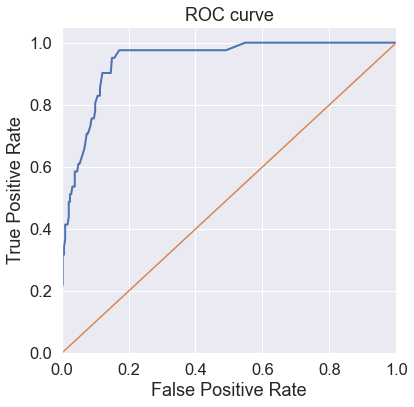

In [43]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(6, 6))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [44]:
pipeline.steps

[('features',
  FeatureUnion(transformer_list=[('fixed_acidity',
                                  Pipeline(steps=[('selector',
                                                   NumberSelector(key='fixed_acidity')),
                                                  ('standard',
                                                   StandardScaler())])),
                                 ('volatile_acidity',
                                  Pipeline(steps=[('selector',
                                                   NumberSelector(key='volatile_acidity')),
                                                  ('standard',
                                                   StandardScaler())])),
                                 ('citric_acid',
                                  Pipeline(steps=[('selector',
                                                   NumberSelector(key='citric_acid')),
                                                  ('sta...
                                            

In [45]:
with open("randf_classifier.dill", "wb") as f:
    dill.dump(pipeline, f)

Проверяем качество на тесте

In [46]:
predictions = pipeline.predict_proba(X_test)
pd.DataFrame({'preds': predictions[:, 1]}).to_csv("test_predictions.csv", index=None)

In [47]:
roc_auc_score(y_score=predictions[:, 1][:], y_true=y_test.iloc[:])

0.942215228603899